In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

import scipy.stats as stats
import matplotlib.pyplot as plt
from chromatic import *
import numpy as np 
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import os
import theano
theano.config.gcc__cxxflags += " -fexceptions"
import starry
from corner import corner
from tqdm.notebook import tqdm
import astropy.units as u
import arviz as az
az.style.use("arviz-darkgrid")
starry.config.lazy = True
starry.config.quiet = True

plt.matplotlib.style.use('default')

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:22:55) 
[GCC 10.3.0]
Running on numpy v1.20.3
Running on chromatic v0.2.7


Create Synthetic Rainbow + Transit

In [2]:
# create polynomial + transit rainbow:
phase = np.loadtxt("/home/patcharapol/work/summer_2022/secondary_eclipse_fitting/phase.txt")
r = Rainbow("/home/patcharapol/work/summer_2022/secondary_eclipse_fitting/data/taylor/S3_miri_lrs_ap2_bg3_Table_Save.txt",format='eureka_S3_txt')
r.time = phase[:-1]*u.d
time_mask = np.logical_and(r.time >= 0.4*u.d, r.time <=0.6*u.d)
b = r.bin(R=100)[10:15,time_mask].normalize()


'''
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)

# add transit:
r = r.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r.nwave))

# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)
'''


100%|█████████████████████████████████████████████| 230/230 [00:00<00:00, 2610.73it/s]

🌈 Warning: 
Of the 88 non-edge new wavelength bins,
13.6% of them effectively contain fewer
than one original wavelength.

Here are your options:
1) Rerun you binning with larger wavelength bin sizes to
decrease the chances that they will be partially populated.
2) Rerun your binning but change `minimum_points_per_bin=` to a number.
This will set a lower limit on the effective number of inputs
points required for each bin. Bins that don't meet this limit
will be marked as not `ok`, and if `trim=True` (default)
these bins will automatically be trimmed away. A threshold
of 1 means bins should average together one or more input
data; a threshold of 0 will get rid of this warning but
allow many bins to come from the same data point, so you
should expect weird correlations.


'\nr = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)\n\n# add transit:\nr = r.inject_transit(\n        planet_radius=np.linspace(0.2, 0.15, r.nwave))\n\n# bin:\nrbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)\n'

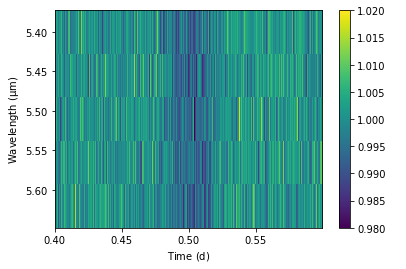

In [3]:
b.imshow(vmax=1.02,vmin=0.98);

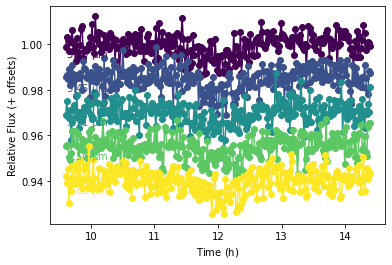

In [4]:
b.plot()

## Fit with PyMC3 Transit Model

Create a transit model

In [5]:
# create transit model:
t = EclipseModel()

# add empty pymc3 model:
t.initialize_empty_model()

# add our parameters:

t.setup_parameters( 
                    stellar_radius = 0.697,
                    stellar_mass = 0.696,
                    stellar_amplitude = WavelikeFitted(Normal, mu=1.0, sigma=0.003),
                    stellar_prot = 1.0,
                    period = Fitted(Normal, mu=1.0,sigma = 0.01,testval=1.0),
                    t0 = Fitted(Normal,  mu=1.0,sigma = 0.01,testval=1.0),
                    planet_log_amplitude = WavelikeFitted(Normal, mu=-2.8, sigma=0.5),
                    inclination = Fitted(Normal, mu=79.0, sigma=5),
                    planet_mass = 0.00206,
                    planet_radius = 0.123829,
                    eccentricity = 0.0,
                    omega = 0.0,
                )
'''
t.setup_parameters(
                  period=1, # a fixed value!
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05), # a value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0 # I will keep this fixed for when we add a polynomial model!
                )
'''
# print a summary of all params:
t.summarize_parameters()

secondaryeclipse_stellar_radius =
  <🧮 Fixed | 0.697 🧮>

secondaryeclipse_stellar_mass =
  <🧮 Fixed | 0.696 🧮>

secondaryeclipse_stellar_amplitude =
  <🧮 WavelikeFitted Normal(mu=1.0, sigma=0.003, name='stellar_amplitude') for each wavelength 🧮>

secondaryeclipse_stellar_prot =
  <🧮 Fixed | 1.0 🧮>

secondaryeclipse_period =
  <🧮 Fitted Normal(mu=1.0, sigma=0.01, testval=1.0, name='period') 🧮>

secondaryeclipse_t0 =
  <🧮 Fitted Normal(mu=1.0, sigma=0.01, testval=1.0, name='t0') 🧮>

secondaryeclipse_planet_log_amplitude =
  <🧮 WavelikeFitted Normal(mu=-2.8, sigma=0.5, name='planet_log_amplitude') for each wavelength 🧮>

secondaryeclipse_inclination =
  <🧮 Fitted Normal(mu=79.0, sigma=5, name='inclination') 🧮>

secondaryeclipse_planet_mass =
  <🧮 Fixed | 0.00206 🧮>

secondaryeclipse_planet_radius =
  <🧮 Fixed | 0.123829 🧮>

secondaryeclipse_eccentricity =
  <🧮 Fixed | 0.0 🧮>

secondaryeclipse_omega =
  <🧮 Fixed | 0.0 🧮>



Now we can attach the data and setup the model!

In [6]:
# attach the Rainbow object to the model:
t.attach_data(b)

# setup the lightcurves for the transit model:
t.setup_lightcurves()

# relate the "actual" data to the model (using a Normal likelihood function)
t.setup_likelihood()

Let's check the model has the parameters we expect:

In [ ]:
print(t.pymc3_model)

Now we can plot a couple of priors - do they look OK?

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Ca

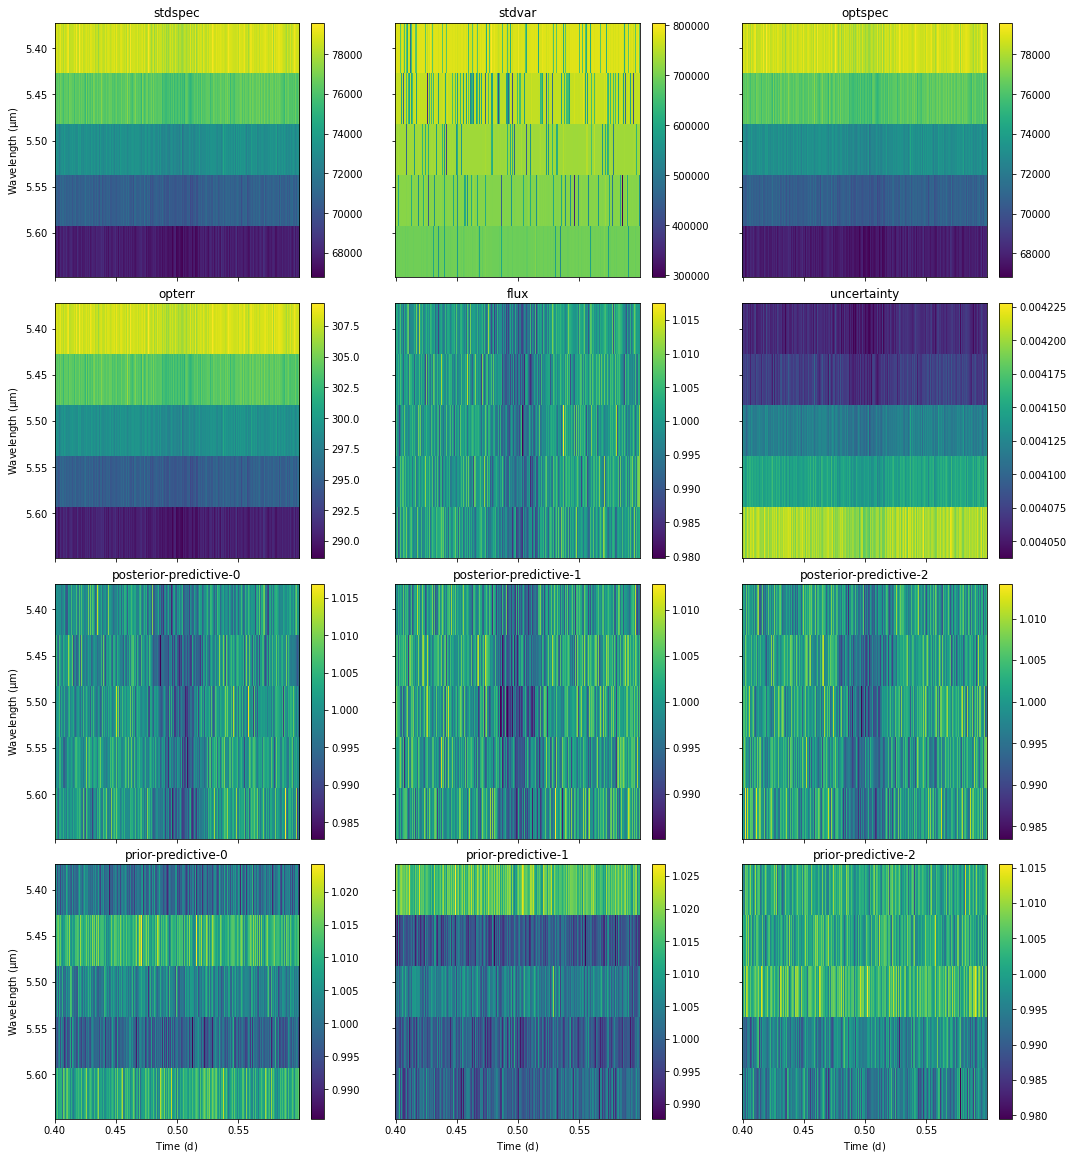

In [47]:
t.plot_priors()

In [ ]:
op_soln = t.optimize()
op_soln

Finally, if we're happy, we can try sampling! This can take a while if there's lots of parameters!

In [ ]:
t.sample(tune=6000, draws=6000, chains=4, cores=4, start= op_soln)

We might want to see a summary table of the MCMC sampling results:

In [25]:
t.summary[:13]["mean"]

stellar_amplitude_w0        0.995
planet_log_amplitude_w0    -2.213
inclination                81.463
period                      1.000
t0                          1.001
stellar_amplitude_w1        0.994
planet_log_amplitude_w1    -2.162
stellar_amplitude_w2        0.995
planet_log_amplitude_w2    -2.207
stellar_amplitude_w3        0.995
planet_log_amplitude_w3    -2.214
stellar_amplitude_w4        0.994
planet_log_amplitude_w4    -2.181
Name: mean, dtype: float64

In [13]:
t.summarize(fmt='wide')

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Ca

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
stellar_amplitude_w0      0.995  0.001   0.993    0.996      0.000    0.000   
planet_log_amplitude_w0  -2.213  0.051  -2.306   -2.114      0.000    0.000   
inclination              81.463  0.234  81.041   81.906      0.001    0.001   
period                    1.000  0.009   0.983    1.016      0.000    0.000   
t0                        1.001  0.005   0.992    1.009      0.000    0.000   
...                         ...    ...     ...      ...        ...      ...   
flux_model_4[273]         1.001  0.000   1.000    1.001      0.000    0.000   
flux_model_4[274]         1.001  0.000   1.000    1.001      0.000    0.000   
flux_model_4[275]         1.001  0.000   1.000    1.001      0.000    0.000   
flux_model_4[276]         1.001  0.000   1.000    1.001      0.000    0.000   
flux_model_4[277]         1.001  0.000   1.000    1.001      0.000    0.000   

                         ess_bulk  ess_tail  r_hat 


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

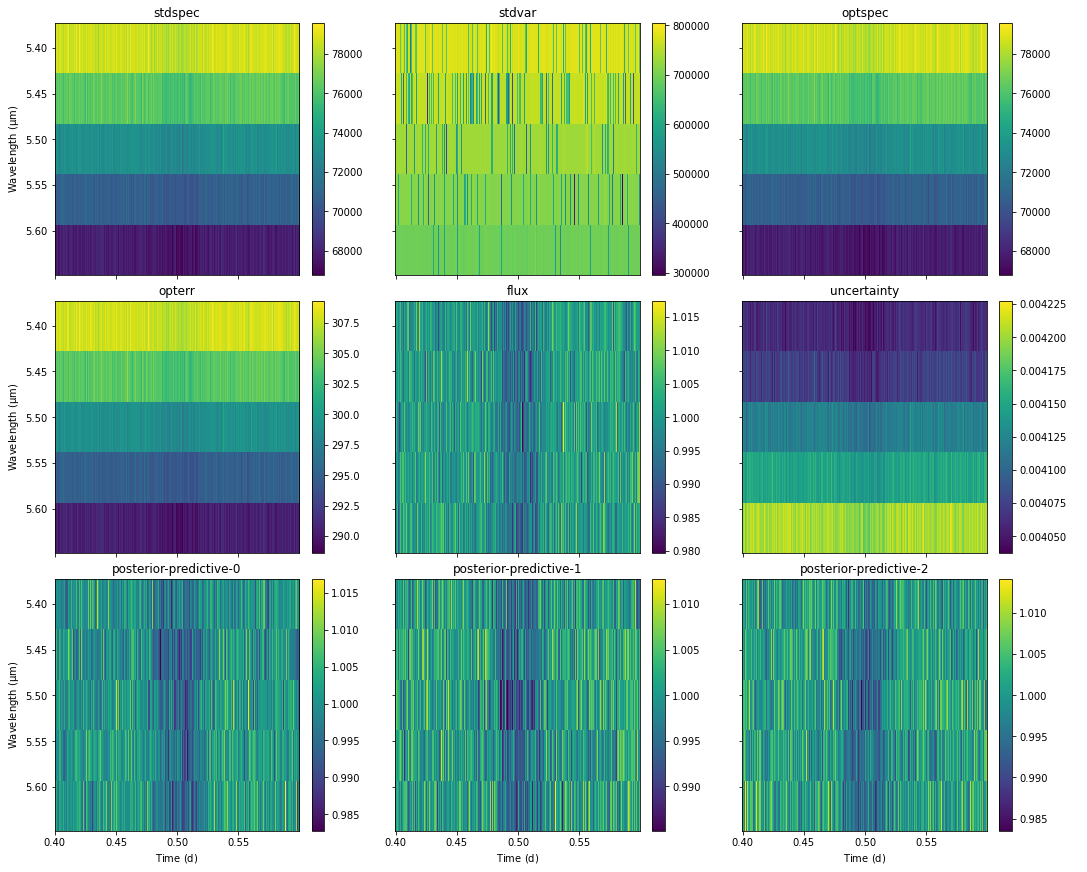

In [30]:
t.plot_posteriors()

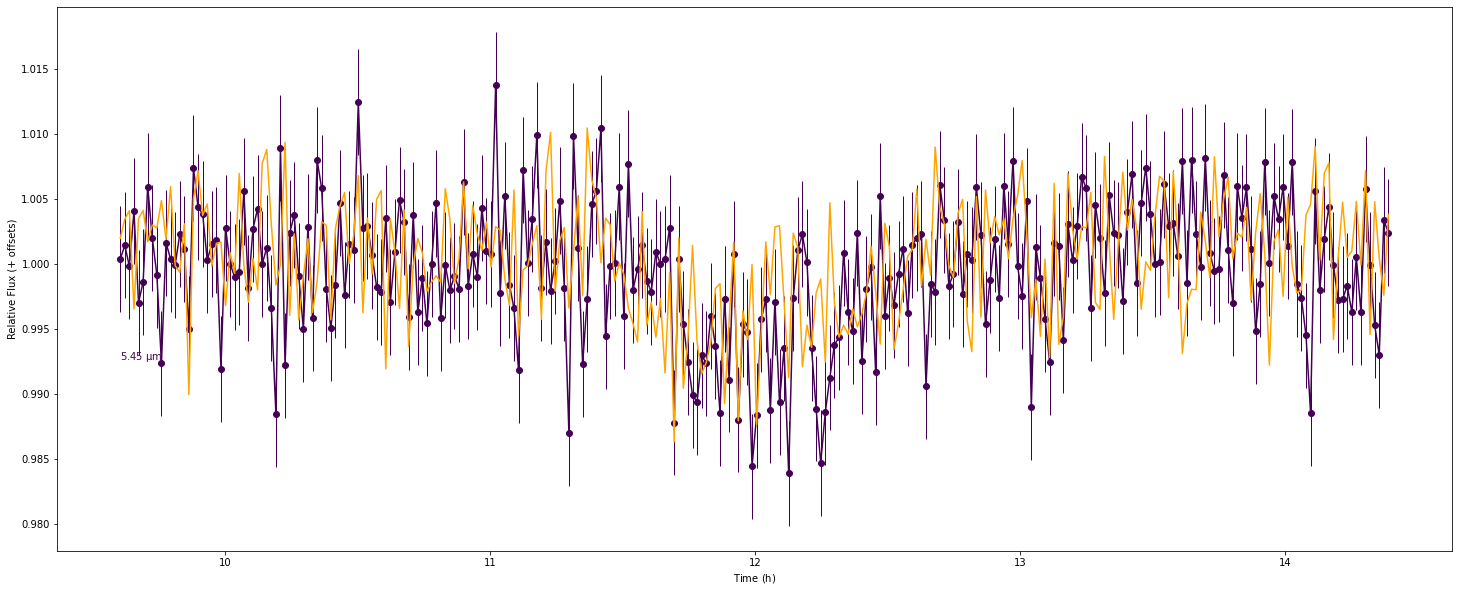

In [46]:
f = plt.figure(figsize=(25,10))
t.data[1,:].plot(errorbar=True)
plt.plot(t.data.time.to_value('h'),t.data.fluxlike["posterior-predictive-1"][1],color='orange')

<Quantity [0.40016552, 0.40088542, 0.40160531, 0.40232521, 0.4030451 ,
           0.403765  , 0.40448489, 0.40520479, 0.40592468, 0.40664458,
           0.40736447, 0.40808437, 0.40880426, 0.40952416, 0.41024405,
           0.41096395, 0.41168384, 0.41240374, 0.41312363, 0.41384353,
           0.41456342, 0.41528332, 0.41600321, 0.41672311, 0.417443  ,
           0.4181629 , 0.41888279, 0.41960269, 0.42032258, 0.42104248,
           0.42176237, 0.42248227, 0.42320216, 0.42392205, 0.42464195,
           0.42536184, 0.42608174, 0.42680163, 0.42752153, 0.42824142,
           0.42896132, 0.42968121, 0.43040111, 0.431121  , 0.4318409 ,
           0.43256079, 0.43328069, 0.43400058, 0.43472048, 0.43544037,
           0.43616027, 0.43688016, 0.43760006, 0.43831995, 0.43903985,
           0.43975974, 0.44047964, 0.44119953, 0.44191943, 0.44263932,
           0.44335922, 0.44407911, 0.44479901, 0.4455189 , 0.4462388 ,
           0.44695869, 0.44767859, 0.44839848, 0.44911837, 0.44983827,
      

In [ ]:
pm.save_trace(t.trace,'eclipse.trace')

In [7]:
with t.pymc3_model:
    t.trace = pm.load_trace('eclipse.trace') 
print (t.trace)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Ca

<MultiTrace: 4 chains, 6000 iterations, 18 variables>


In [ ]:
t.setup_parameters( 
                    stellar_amplitude = 0.004,
                    period = 1.001,
                    t0 = 1.001,
                    planet_log_amplitude = -4.532,
                    inclination = 82.199,
                )

In [ ]:
t.setup_orbit()

In [ ]:
t.parameters

In [ ]:
flux = t.orbit.flux(t.data.time).eval()

In [ ]:
plt.plot(t.data.time,1+flux)
plt.scatter(t.data.time,t.data.flux[0])

In [ ]:
sample_post = t.sample_posterior()

In [ ]:
sample_post.keys()

In [ ]:
plt.plot(t.data.time,sample_post['wavelength_0_data'][0],color='orange')
plt.plot(t.data.time,t.data.fluxlike["posterior-predictive-0"][0],color='red')
plt.plot(t.data.time,t.data.flux[0])

In [ ]:
t.data.fluxlike['residuals-0'] = t.data.fluxlike['posterior-predictive-0'][0] - t.data.flux[0]

In [ ]:
plt.plot(t.data.time,t.data.fluxlike['posterior-predictive-0'][0] - t.data.flux[0])

We might also want to see a couple of posterior samples as a "quick-look" check!

## Add a polynomial!

In [ ]:
# create wavelength-dep linear + constant model:
poly = [(0.005*i*b.time.to_value()) + (0.01*i) for i in range(b.nwave)]

# add this model to the Rainbow
rp = b._create_copy()
rp.flux = rp.flux + poly
rp.fluxlike['polynomial_model'] = np.array(poly)
rp.imshow_quantities();

Now we want to define a polynomial model:

In [ ]:
# set up polynomial model:
pol = PolynomialModel(degree=2)
pol.initialize_empty_model()
pol.setup_parameters(
    p=WavelikeFitted(Uniform,testval=[0,0],upper=[0.1,0.1],lower=[-0.1,-0.1])
)

# we need to be careful (in this version!) with the baseline in the transit model and a constant term in the
# polynomial model - we don't want to have 2 fitted offset terms!

Combine the transit + polynomial models!

In [ ]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()

# attach the models we want:
cm.attach_models({'transit':t,'polynomial':pol})
# attach the new data
cm.attach_data(rp)

# setup model as before:
cm.setup_lightcurves()
cm.setup_likelihood()

Let's see the constituent models:

In [ ]:
print(cm.chromatic_models)

In [ ]:
print(cm.pymc3_model)

In [ ]:
cm.sample(tune=3000, draws=3000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

In [ ]:
cm.plot_posteriors()

### Hopefully should look pretty good!

We can always subtract our polynomial model and look at what's left:

In [ ]:
cm.data.fluxlike['residuals-0'] = cm.data.fluxlike['posterior-predictive-0'] - poly

We should just have the transit model now:

In [ ]:
cm.data.imshow(quantity='residuals-0');

Subtracting the transit model (from chromatic defaults)

In [ ]:
import batman

# Defaults for planet simulation.
defaults = {
        "t0": 0,
        "per": 3,
        "a": 10,
        "inc": 90,
        "ecc": 0,
        "w": 0,
        "limb_dark": "nonlinear",
        "u": [0.5, 0.1, 0.1, -0.1],
    }
    
# Initialize batman model.
params = batman.TransitParams()
params.t0 = defaults["t0"]
params.per = defaults["per"]
params.a = defaults["a"]
params.inc = defaults["inc"]
params.ecc = defaults["ecc"]
params.w = defaults["w"]
params.limb_dark = defaults["limb_dark"]
params.u = defaults["u"]

injected_radii = np.linspace(0.2, 0.15, rp.nwave)
planet_flux = np.zeros((rp.nwave, rp.ntime))
for i in range(rp.nwave):
    params.rp = injected_radii[i]

    m = batman.TransitModel(params, rp.time.to_value("day"))
    planet_flux[i] = m.light_curve(params)

In [ ]:
cm.data.fluxlike['residuals-0'] = cm.data.fluxlike['residuals-0'] - planet_flux

In [ ]:
cm.data.imshow(quantity='residuals-0');